# Final Notebook 001

## Import

In [2]:
import sentisignal
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np 
import pylab as P 
import ast
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import scipy.stats as s
import statsmodels.api as sm
import pprint

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from datetime import datetime
from yahoo_finance import Share
from pandas_datareader import data, wb
from statsmodels.graphics.api import qqplot
from operator import itemgetter
from decimal import *

## Configuration

In [4]:
data_primary_path = '../../data/csv/stocktwits_twitter_withretweets_daily.csv'
data_symbology_path = '../../data/csv/symbology.csv'
data_pickles_path = '../../data/pickles/'
data_nasdaq_company_list_path = '../../data/nasdaq/companylist.csv'
start_date = '2012-01-01'
end_date = '2012-01-03'

In [14]:
plot_width = 8
plot_height = 8

## Data Acquisition

In [7]:
data_symbology = pd.read_csv(data_symbology_path)

### Use NASDAQ data to get top 100 companies by MarketCap

In [8]:
data_nasdaq_company_list = pd.read_csv(data_nasdaq_company_list_path)
data_nasdaq_top_100_mkt_cap = data_nasdaq_company_list.head(100)
data_nasdaq_top_100_mkt_cap_symbols = data_nasdaq_top_100_mkt_cap['Symbol'].unique()

### Calculate breakdown per sector (using PsychSignal symbology)

In [9]:
data_nasdaq_top_100_mkt_cap_symbology = pd.merge(data_nasdaq_top_100_mkt_cap, data_symbology, left_on='Symbol', right_on='symbol', how = "left")
# data_nasdaq_top_100_mkt_cap_symbology.info()
data_nasdaq_top_100_mkt_cap_symbology_sector_size = data_nasdaq_top_100_mkt_cap_symbology.groupby(['sector']).size()
print data_nasdaq_top_100_mkt_cap_symbology_sector_size

sector
Consumer Goods       4
Financial            7
Healthcare          13
Industrial Goods     1
Services            25
Technology          30
dtype: int64


(-1.0128662320463357, 1.0, -1.0193658825849057, 1.0141629122482432)

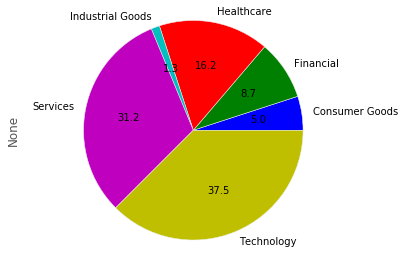

In [10]:
data_nasdaq_top_100_mkt_cap_symbology_sector_size.plot(kind='pie', autopct='%.1f')
plt.axis('equal')
# plt.title('NASAQ Top 100 (by MarketCap) by Sector')

### Calculate and graph yearly mean of average monthly messages

In [11]:
sum_avg_cols = [col for col in data_nasdaq_top_100_mkt_cap_symbology.columns if ('all_scanned_20' in col and 'avg_monthly' in col)]
data_nasdaq_top_100_mkt_cap_symbology['mean_avg_monthly'] = data_nasdaq_top_100_mkt_cap_symbology[sum_avg_cols].sum(axis=1)/len(sum_avg_cols)

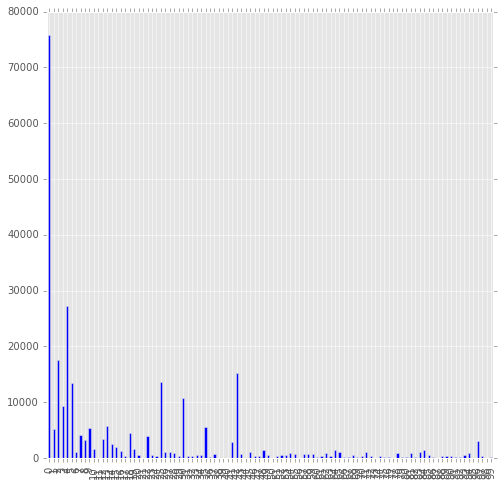

In [15]:
fig = plt.figure(figsize=(plot_width, plot_height))
ax = fig.add_subplot(111)
data_nasdaq_top_100_mkt_cap_symbology['mean_avg_monthly'].plot(kind='bar')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
plt.show()

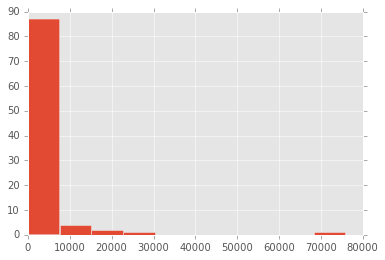

In [17]:
data_nasdaq_top_100_mkt_cap_symbology.hist(column=['mean_avg_monthly'])
plt.title('')

### Correlation matrix

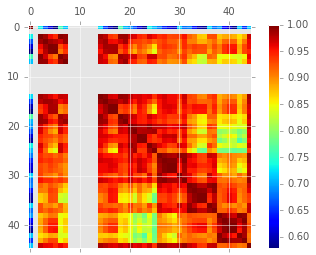

In [29]:
fig = plt.figure()
data_nasdaq_top_100_mkt_cap_symbology_corr = data_nasdaq_top_100_mkt_cap_symbology.corr()
# plt.matshow(data_nasdaq_top_100_mkt_cap_symbology_corr)
# plt.colorbar(data_nasdaq_top_100_mkt_cap_symbology_corr)

labels = data_nasdaq_top_100_mkt_cap_symbology_corr.columns
# print labels
ax = fig.add_subplot(111)
cax = ax.matshow(data_nasdaq_top_100_mkt_cap_symbology_corr, interpolation='nearest')
fig.colorbar(cax)

# ax.set_xticklabels(['']+labels)
# ax.set_yticklabels(['']+labels)

### MarketCap and mean_avg_monthly regression

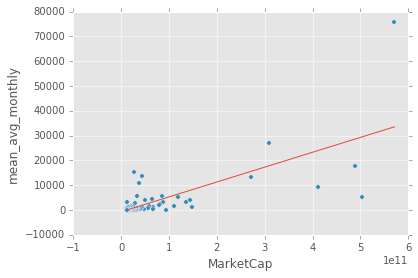

In [19]:
data_nasdaq_top_100_mkt_cap_symbology.plot(kind='scatter', x='MarketCap', y='mean_avg_monthly')
x = data_nasdaq_top_100_mkt_cap_symbology['MarketCap']
y = data_nasdaq_top_100_mkt_cap_symbology['mean_avg_monthly']
idx = np.isfinite(x) & np.isfinite(y)
m, b = np.polyfit(x[idx], y[idx], 1)
plt.plot(x, m*x + b, '-')

### Subsample sentiment data (Daily Stocktwits and Twitter)

In [20]:
data_nasdaq_top_100_sentiment = sentisignal.subsample_data(data_primary_path, data_symbology_path, data_pickles_path, start_date, end_date, 'SYMBOL', data_nasdaq_top_100_mkt_cap_symbols, False)

Loaded from pre-created pickle


In [36]:
data_nasdaq_top_100_sentiment.head()

,SOURCE,SYMBOL,TIMESTAMP_UTC,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,BULL_BEAR_MSG_RATIO,TOTAL_SCANNED_MESSAGES,EXCHANGE,SECTOR,INDUSTRY,TITLE,DATE
20654,stocktwits+twitter_withretweets,AAPL,2012-01-02T05:00:00Z,1.73,1.27,0.46,31,9,3.44,425,NASDAQ,Technology,Personal Computers,Apple Inc.,2012-01-02
105417,stocktwits+twitter_withretweets,ADBE,2012-01-02T05:00:00Z,1.96,2.11,-0.15,1,1,1.00,2,NASDAQ,Technology,Application Software,Adobe Systems Inc.,2012-01-02
125056,stocktwits+twitter_withretweets,ADSK,2012-01-02T05:00:00Z,1.96,0.00,1.96,1,0,0.00,1,NASDAQ,Technology,Technical & System Software,"Autodesk, Inc.",2012-01-02
287963,stocktwits+twitter_withretweets,ALXN,2012-01-02T05:00:00Z,2.18,0.00,2.18,4,0,0.00,17,NASDAQ,Healthcare,Biotechnology,"Alexion Pharmaceuticals, Inc.",2012-01-02
293680,stocktwits+twitter_withretweets,AMAT,2012-01-02T05:00:00Z,0.00,0.00,0.00,0,0,0.00,1,NASDAQ,Technology,Semiconductor Equipment & Materials,Applied Materials Inc.,2012-01-02


In [42]:
data_nasdaq_top_100_mkt_cap_symbols

array(['AAPL', 'GOOGL', 'GOOG', 'MSFT', 'FB', 'AMZN', 'CMCSA', 'INTC',
       'CSCO', 'GILD', 'AMGN', 'KHC', 'SBUX', 'WBA', 'CELG', 'QCOM',
       'COST', 'MDLZ', 'PCLN', 'BIIB', 'TXN', 'FOX', 'BIDU', 'ESRX',
       'PYPL', 'NFLX', 'ADBE', 'REGN', 'AVGO', 'ADP', 'QQQ', 'CTSH',
       'FOXA', 'ALXN', 'CME', 'YHOO', 'LBTYA', 'TMUS', 'LILAK', 'LBTYK',
       'LILA', 'EBAY', 'TSLA', 'NXPI', 'LBTYB', 'MNST', 'ORLY', 'INTU',
       'AAL', 'CSX', 'LVNTA', 'ROST', 'DISH', 'JD', 'ATVI', 'ILMN',
       'LVNTB', 'MYL', 'AMAT', 'VRTX', 'FISV', 'EQIX', 'ISRG', 'CHTR',
       'EA', 'SIRI', 'PAYX', 'PCAR', 'DLTR', 'TROW', 'CERN', 'NVDA', 'MAR',
       'QVCB', 'ADI', 'VIA', 'AMTD', 'QVCA', 'EXPE', 'CHKP', 'IBKR',
       'SNDK', 'NTRS', 'BMRN', 'SWKS', 'CTRP', 'HSIC', 'VIAB', 'INCY',
       'FITB', 'FAST', 'VRSK', 'LMCA', 'ADSK', 'VOD', 'LMCK', 'MU', 'CA',
       'LMCB', 'SBAC'], dtype=object)

In [43]:
data_nasdaq_top_100_finance = sentisignal.get_data_finance('yahoo', data_nasdaq_top_100_mkt_cap_symbols, start_date, end_date, data_pickles_path, False, 'NaN')

Loaded from pre-created pickle


In [41]:
# data_nasdaq_top_100_sentiment = pre
data_nasdaq_top_100_merge = sentisignal.merge_sentiment_finance(data_nasdaq_top_100_sentiment, data_nasdaq_top_100_finance, True, True, False)
data_nasdaq_top_100_merge.head()

,SOURCE,SYMBOL,TIMESTAMP_UTC,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,BULL_BEAR_MSG_RATIO,TOTAL_SCANNED_MESSAGES,...,SECTOR,INDUSTRY,TITLE,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ CLOSE
0,stocktwits+twitter_withretweets,AAPL,2012-01-02T05:00:00Z,1.73,1.27,0.46,31,9,3.44,425,...,Technology,Personal Computers,Apple Inc.,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1,stocktwits+twitter_withretweets,ADBE,2012-01-02T05:00:00Z,1.96,2.11,-0.15,1,1,1.00,2,...,Technology,Application Software,Adobe Systems Inc.,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2,stocktwits+twitter_withretweets,ADSK,2012-01-02T05:00:00Z,1.96,0.00,1.96,1,0,0.00,1,...,Technology,Technical & System Software,"Autodesk, Inc.",2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN
3,stocktwits+twitter_withretweets,ALXN,2012-01-02T05:00:00Z,2.18,0.00,2.18,4,0,0.00,17,...,Healthcare,Biotechnology,"Alexion Pharmaceuticals, Inc.",2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN
4,stocktwits+twitter_withretweets,AMAT,2012-01-02T05:00:00Z,0.00,0.00,0.00,0,0,0.00,1,...,Technology,Semiconductor Equipment & Materials,Applied Materials Inc.,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN


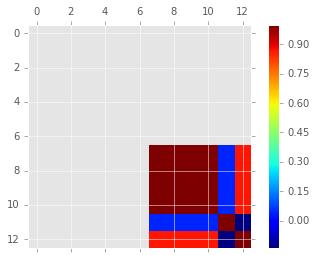

In [30]:
fig = plt.figure()
data_nasdaq_top_100_merge_corr = data_nasdaq_top_100_merge.corr()
# plt.matshow(data_nasdaq_top_100_mkt_cap_symbology_corr)
# plt.colorbar(data_nasdaq_top_100_mkt_cap_symbology_corr)

labels = data_nasdaq_top_100_merge_corr.columns
ax = fig.add_subplot(111)
cax = ax.matshow(data_nasdaq_top_100_merge_corr, interpolation='nearest')
fig.colorbar(cax)

# ax.set_xticklabels(['']+labels)
# ax.set_yticklabels(['']+labels)

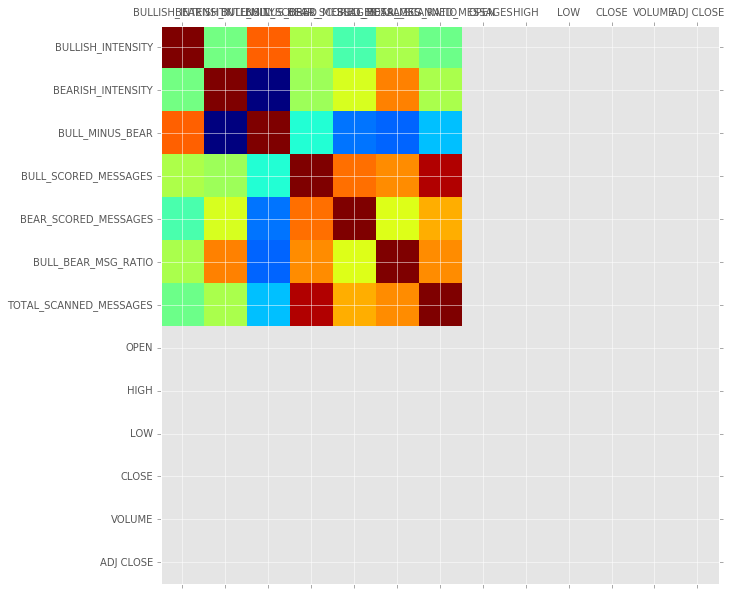

In [39]:
sentisignal.plot_corr(data_nasdaq_top_100_merge)

In [40]:
data_nasdaq_top_100_merge.corr()

,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,BULL_BEAR_MSG_RATIO,TOTAL_SCANNED_MESSAGES,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ CLOSE
BULLISH_INTENSITY,1.000000,0.212711,0.703098,0.323120,0.134100,0.314241,0.201244,NaN,NaN,NaN,NaN,NaN,NaN
BEARISH_INTENSITY,0.212711,1.000000,-0.545263,0.292619,0.398318,0.646349,0.316442,NaN,NaN,NaN,NaN,NaN,NaN
BULL_MINUS_BEAR,0.703098,-0.545263,1.000000,0.064251,-0.174831,-0.200792,-0.057644,NaN,NaN,NaN,NaN,NaN,NaN
BULL_SCORED_MESSAGES,0.323120,0.292619,0.064251,1.000000,0.679551,0.631332,0.928475,NaN,NaN,NaN,NaN,NaN,NaN
BEAR_SCORED_MESSAGES,0.134100,0.398318,-0.174831,0.679551,1.000000,0.412349,0.574185,NaN,NaN,NaN,NaN,NaN,NaN
BULL_BEAR_MSG_RATIO,0.314241,0.646349,-0.200792,0.631332,0.412349,1.000000,0.626730,NaN,NaN,NaN,NaN,NaN,NaN
TOTAL_SCANNED_MESSAGES,0.201244,0.316442,-0.057644,0.928475,0.574185,0.626730,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
OPEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HIGH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
data_nasdaq_top_100_merge

,SOURCE,SYMBOL_x,TIMESTAMP_UTC,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,BULL_BEAR_MSG_RATIO,TOTAL_SCANNED_MESSAGES,...,INDUSTRY,TITLE,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ CLOSE,SYMBOL_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2012-01-03,409.399998,412.499989,408.999989,411.230000,75555200,54.405100,AAPL
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2012-01-03,14.300000,14.400000,14.010000,14.040000,11701100,13.145011,NVDA
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2012-01-03,62.610001,64.169998,62.349998,62.549999,3501600,31.275000,CERN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2012-01-03,58.509998,59.070000,57.520000,57.590000,1657400,51.286601,TROW
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2012-01-03,84.400002,84.529999,82.209999,82.430000,3062000,41.215000,DLTR
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2012-01-03,38.570000,39.380001,38.360001,38.799999,2803800,34.137813,PCAR
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2012-01-03,30.670000,30.730000,30.389999,30.430000,2815400,26.100382,PAYX
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2012-01-03,1.840000,1.880000,1.830000,1.860000,44067300,1.826426,SIRI
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2012-01-03,21.049999,21.450001,21.020000,21.299999,4859500,21.299999,EA
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2012-01-03,29.879999,30.280001,29.820000,30.000000,3290500,28.344086,MAR
